In [2]:
from PIL import Image
from pynq import Overlay, allocate
import numpy as np
import pynq.lib.dma
import pynq.lib.video
import time
import cv2
from pynqmetadata.frontends import Metadata
from pynq import PL
import pynq.mmio
from pynq import MMIO

# PL.reset()

# Load the overlay
overlay = Overlay("/home/xilinx/jupyter_notebooks/kevin/overlay9/design_1.bit", download=True)
help(overlay)
overlay.ip_dict

# overlay3 - provided design + GPT Modified, DMA, using 14 bits buffer
# overlay4 - provided design + GPT Modified (iirc), DMA, using 26 bits buffer
# overlay5 - personal design, DMA 
# overlay6 - first VDMA design
# overlay7 - DMA without IP
# overlay8 - overlay5, but using ap_axiu<32,0,0,0>, meaning no side-channel
# overlay9 - threshold, no DMA, runs on MMIO, no changes to config header files
# overlay10 - overlay5, axiu not modified, added constant for TREADY signal
# overlay11 - overlay10, but with AXI4-Stream Data Width Controller
# Overlay12 - Increment IP built in Verilog
# Overlay13 - BGR2GRAY, no DMA, runs on MMIO, INPUT PTR WIDTH wrongly formatted
# Overlay14 - RGB2GRAY, no DMA, runs on MMIO, INPUT 32 OUTPUT 8

Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay /home/xilinx/jupyter_notebooks/kevin/overlay9/design_1.bit. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    threshold_accel_0    : pynq.overlay.DefaultIP
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



{'threshold_accel_0': {'type': 'xilinx.com:hls:threshold_accel:1.0',
  'mem_id': 's_axi_control_r',
  'memtype': 'REGISTER',
  'gpio': {},
  'interrupts': {},
  'parameters': {'C_M_AXI_GMEM1_ADDR_WIDTH': '64',
   'C_M_AXI_GMEM1_ARUSER_WIDTH': '1',
   'C_M_AXI_GMEM1_AWUSER_WIDTH': '1',
   'C_M_AXI_GMEM1_BUSER_WIDTH': '1',
   'C_M_AXI_GMEM1_CACHE_VALUE': '"0011"',
   'C_M_AXI_GMEM1_DATA_WIDTH': '32',
   'C_M_AXI_GMEM1_ID_WIDTH': '1',
   'C_M_AXI_GMEM1_PROT_VALUE': '"000"',
   'C_M_AXI_GMEM1_RUSER_WIDTH': '1',
   'C_M_AXI_GMEM1_USER_VALUE': '0x00000000',
   'C_M_AXI_GMEM1_WUSER_WIDTH': '1',
   'C_M_AXI_GMEM2_ADDR_WIDTH': '64',
   'C_M_AXI_GMEM2_ARUSER_WIDTH': '1',
   'C_M_AXI_GMEM2_AWUSER_WIDTH': '1',
   'C_M_AXI_GMEM2_BUSER_WIDTH': '1',
   'C_M_AXI_GMEM2_CACHE_VALUE': '"0011"',
   'C_M_AXI_GMEM2_DATA_WIDTH': '32',
   'C_M_AXI_GMEM2_ID_WIDTH': '1',
   'C_M_AXI_GMEM2_PROT_VALUE': '"000"',
   'C_M_AXI_GMEM2_RUSER_WIDTH': '1',
   'C_M_AXI_GMEM2_USER_VALUE': '0x00000000',
   'C_M_AXI_GMEM2_WU

In [3]:
# cvt = overlay.cvtcolor_0
threshold = overlay.threshold_accel_0
threshold.register_map

### Config for DMA

# dma = overlay.axi_dma_0
# dma_send = dma.sendchannel
# dma_recv = dma.recvchannel

### Config for VDMA

# vdma = pynq.lib.video.dma.AxiVDMA
# vdma_read = vdma.S2MMChannel
# vdma_send = vdma.MM2SChannel

RegisterMap {
  img_inp_1 = Register(img_inp=write-only),
  img_inp_2 = Register(img_inp=write-only),
  img_out_1 = Register(img_out=write-only),
  img_out_2 = Register(img_out=write-only)
}

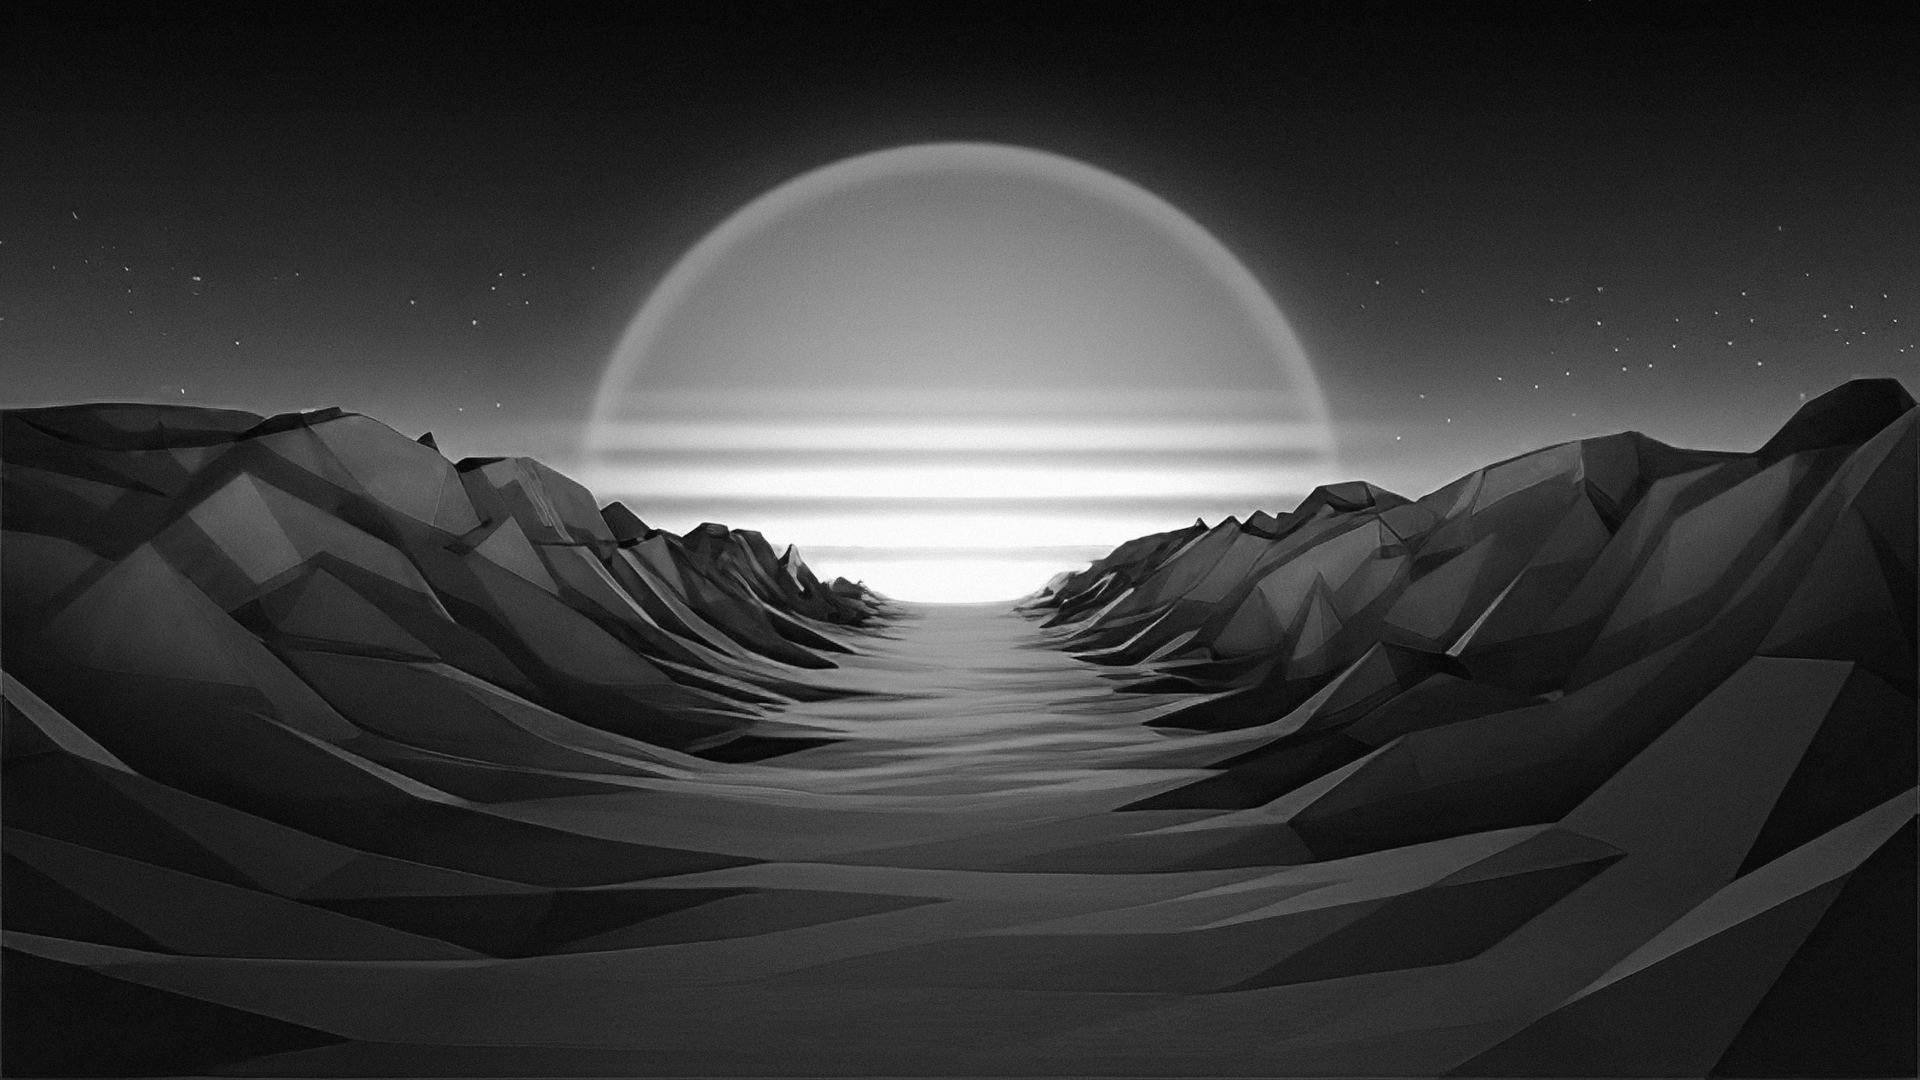

In [4]:
img_path = "/home/xilinx/jupyter_notebooks/kevin/ip24/src/lol.jpg"

img_lol = cv2.imread(img_path,-1)
img = cv2.cvtColor(img_lol, cv2.COLOR_BGR2GRAY)
# img = img.astype(np.uint8)

height, width = img.shape

in_buffer = allocate(shape=(height,width), dtype=np.uint8)
out_buffer = allocate(shape=(height,width), dtype=np.uint8)

in_buffer[:] = img

buf_image = Image.fromarray(in_buffer)
display(buf_image)

In [5]:
ip_base_addr_ctrl = 0x40000000
ip_base_addr_ctrl_r = 0x40010000
addr_range = 0xFFFF

mmio_ctrl = MMIO(ip_base_addr_ctrl, addr_range)
mmio_ctrl_r = MMIO(ip_base_addr_ctrl_r, addr_range)

378535936
380633088


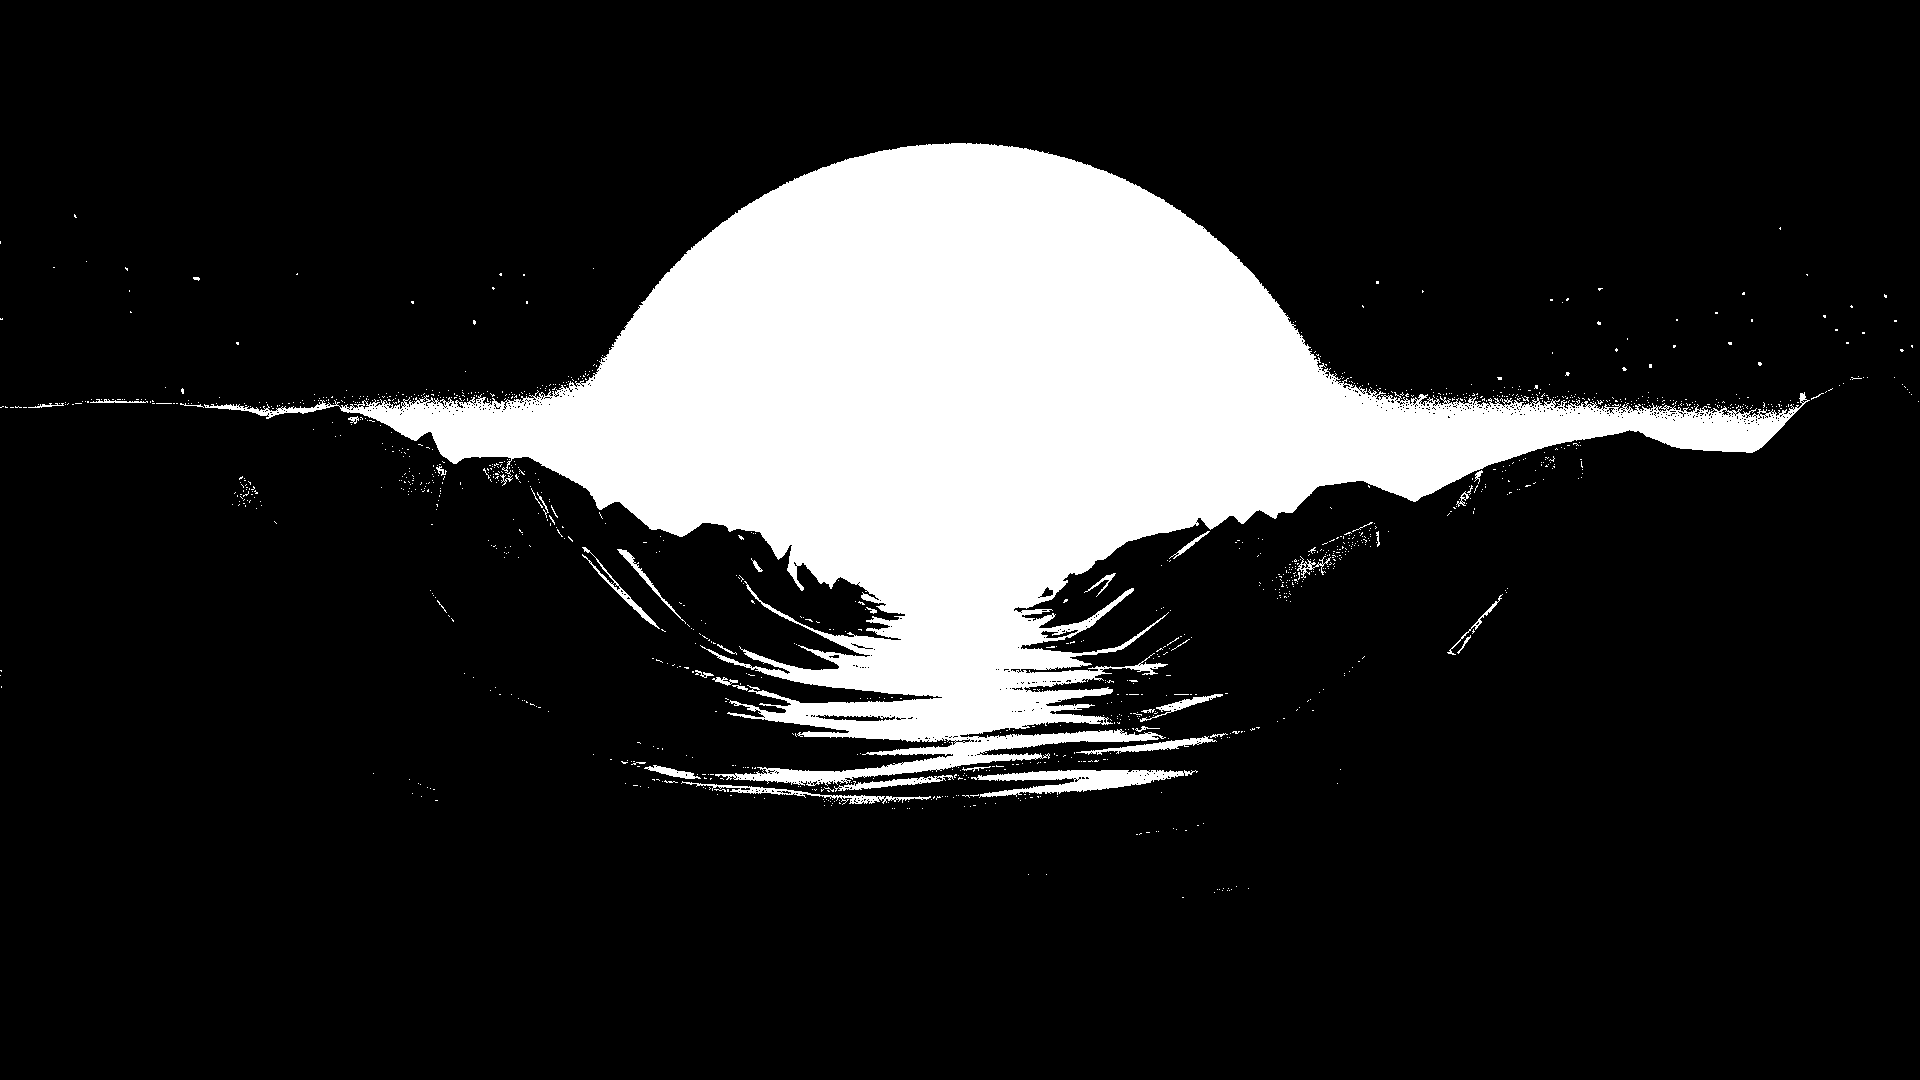

<bound method PynqBuffer.flush of PynqBuffer([[0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            ...,
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0],
            [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [10]:
mmio_ctrl.write(0x00,2)
mmio_ctrl.write(0x10,100) # threshold
mmio_ctrl.write(0x18,255) # maxval
mmio_ctrl.write(0x20,height)
mmio_ctrl.write(0x28,width)

mmio_ctrl_r.write(0x10,in_buffer.device_address)
print(in_buffer.device_address)
mmio_ctrl_r.write(0x1c,out_buffer.device_address)
print(out_buffer.device_address)

mmio_ctrl.write(0x00,0x1)

buf_image = Image.fromarray(out_buffer)
display(buf_image)

in_buffer.flush
out_buffer.flush


In [11]:
### Test on jpeg image

image_path = "/home/xilinx/jupyter_notebooks/kevin/ip24/src/lol.jpg"

original_image = Image.open(image_path)
original_image.load()

input_array = np.array(original_image)

xres, yres = original_image.size
print("Xres: ", xres) # width, cols, 0x18
print("Yres: ", yres) # height, rows, 0x10 

xres_address = 0x18
yres_address = 0x10

in_buffer = allocate(shape=(yres,xres,3), dtype=np.uint8)
out_buffer = allocate(shape=(yres,xres), dtype=np.uint8)

in_buffer[:] = input_array

buf_image = Image.fromarray(in_buffer)
display(buf_image)

cvt.write(xres_address, xres)
cvt.write(yres_address, yres)

def run_kernel():
    dma_send.transfer(in_buffer)
    dma_recv.transfer(out_buffer)
    
    print("Run kernel")
    cvt.write(0x00, 0x01)
    
    dma_send.wait()
    val = cvt.read(0x00) # reads the value at address 0x00
    print(bin(val))
    dma_recv.wait()
    print("WTF")
    
run_kernel()

buf_image2 = Image.fromarray(out_buffer)
display(buf_image2)


Xres:  1920
Yres:  1080


KeyboardInterrupt: 